In [3]:
import os
import glob
from sklearn.model_selection import train_test_split
from dataset import make_ds
from monai.data import DataLoader 
import matplotlib.pyplot as plt
import torch
from train_reconstruction import swinunetplussig, lossf
import pandas as pd
import torch

In [4]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
image_dir = '/media/sdb/Maryam/brats21'

# Define patterns for matching file types
patterns = {
    't1': '*t1.nii.gz',
    't2': '*t2.nii.gz',
    'flair': '*flair.nii.gz',
    't1ce': '*t1ce.nii.gz',
    'seg': '*seg.nii.gz',
}

# Assuming the patient folders are directly under the image_dir
brats_folders = os.listdir(image_dir)

# Create a data dictionary
data_dicts = []
for patient in brats_folders:
    patient_folder = os.path.join(image_dir, patient)
    patient_dict = {}
    for modality, pattern in patterns.items():
        # Use glob to find files matching the pattern for each modality
        files = glob.glob(os.path.join(patient_folder, pattern))
        if files:
            # Assuming the first match is the correct one
            patient_dict[modality] = files[0]
        else:
            # Handle case where no matching file is found
            print(f"No matching file for {modality} in {patient_folder}")
    if len(patient_dict) == len(patterns):  # Ensure all modalities are found
        data_dicts.append(patient_dict)
    else:
        print(f"Missing modalities for patient {patient}, skipping...")

In [4]:
train_dicts, temp_dicts = train_test_split(data_dicts, test_size=0.4, random_state=121274)

val_dicts, test_dicts = train_test_split(temp_dicts, test_size=0.75, random_state=121274)  

dataset_tr, dataset_val, dataset_ts = make_ds(train_dicts, val_dicts, test_dicts)

/media/sdb/Maryam/anaconda3/lib/python3.8/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.
  warn_deprecated(argname, msg, warning_category)
/media/sdb/Maryam/anaconda3/lib/python3.8/site-packages/monai/utils/deprecate_utils.py:111: FutureWarning: <class 'monai.transforms.utility.dictionary.AddChanneld'>: Class `AddChanneld` has been deprecated since version 0.8. It will be removed in version 1.3. please use MetaTensor data type and monai.transforms.EnsureChannelFirstd instead with `channel_dim='no_channel'`.
  warn_deprecated(obj, msg, warning_category)
/media/sdb/Maryam/anaconda3/lib/python3.8/site-packages/monai/utils/deprecate_utils.py:221: FutureWarning: monai.transforms.utility.dictionary EnsureChannelFirstd.__init__:meta_keys: Argument `meta_keys` has been

In [5]:
dataloader_tr = DataLoader(dataset_tr, batch_size=1, shuffle=True, num_workers=2, pin_memory=True)
dataloader_val = DataLoader(dataset_val, batch_size=1, shuffle=True, num_workers=2, pin_memory=True)
dataloader_ts = DataLoader(dataset_ts, batch_size=1, shuffle= False, num_workers=2, pin_memory=True)

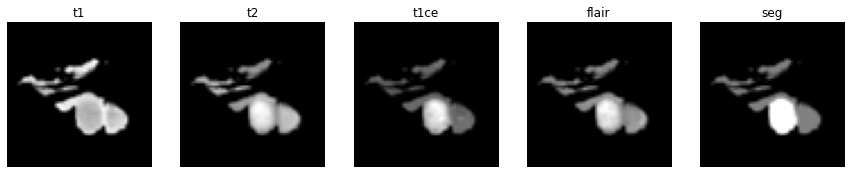

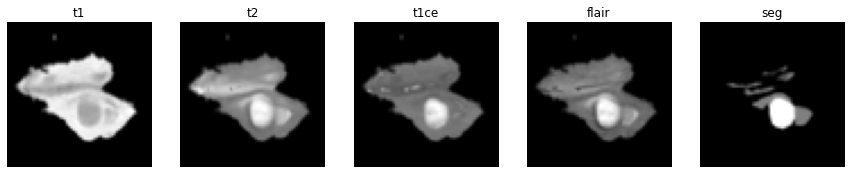

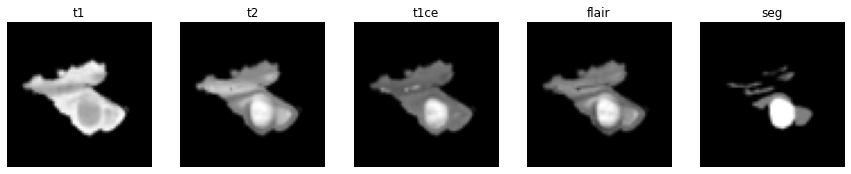

In [10]:
batch_data = next(iter(dataloader_ts))

# Define a function to plot images
def plot_images(batch, type_dic, modality_keys, slice_idx=30):
    """
    Plots a single slice from each modality for the first item in the batch.
    
    Parameters:
    - batch: the batch of data from the DataLoader.
    - modality_keys: list of keys for each modality to plot.
    - slice_idx: the index of the slice to plot.
    """
    fig, axs = plt.subplots(1, len(modality_keys), figsize=(15, 5))
    for i, key in enumerate(modality_keys):
        # Assuming the first dimension is the batch size and images are 4D (B, C, H, W, D)
        image = batch[type_dic][key][0, 0, :, :, slice_idx].detach().cpu().numpy()  # Get the first item, first channel
        axs[i].imshow(image, cmap='gray')
        axs[i].set_title(key)
        axs[i].axis('off')
    plt.show()

# Define the keys for the modalities you want to plot
modality_keys = ["t1", "t2", "t1ce", "flair", "seg"]

# Plot images for a selected slice
plot_images(batch_data,'tum', modality_keys, slice_idx=40)
plot_images(batch_data, 'surr1', modality_keys, slice_idx=40)
plot_images(batch_data, 'surr2', modality_keys, slice_idx=40)

In [11]:
device = torch.device("cuda:0" )#if torch.cuda.is_available() else "cpu")
model = swinunetplussig(device)
model_path = '/media/sdb/Maryam/surrounding_prognosis/saved_models/Reconstruction_epch_last.pth'
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

Evaluation of model on test set

In [15]:
model.eval()  # Put the model in evaluation mode

with torch.no_grad():  # Disable gradient calculation
    total_loss = 0
    count = 0  # Count to average the loss

    for batch_data in dataloader_ts:
        # Similar to the training loop but without the optimizer steps
        for condition in ['tum', 'surr1', 'surr2']:
            for sequence in ['t1', 't2', 't1ce', 'flair']:
                inputs = batch_data[condition][sequence].to(device)
                outputs = model(inputs)
                loss = lossf(outputs, inputs)  # Calculate the loss
                total_loss += loss.item()  # Aggregate the loss
                count += 1  # Increment count

    avg_loss = total_loss / count  # Calculate the average loss
    print(f"Average loss on test set: {avg_loss:.4f}")

Average loss on test set: -0.9999


In [19]:
model.eval()
step_test = 0
loss_test = 0
with torch.no_grad():
    for batch_data in dataloader_ts:
        step_test += 1
        for condition in ['tum', 'surr1', 'surr2']:
            for sequence in ['t1', 't2', 't1ce', 'flair']:
                
                inputs = batch_data[condition][sequence].to(device)
                outputs = model(inputs)
                loss = lossf(outputs, inputs)
                loss_test += loss.item()
loss_test /= len(dataloader_ts)

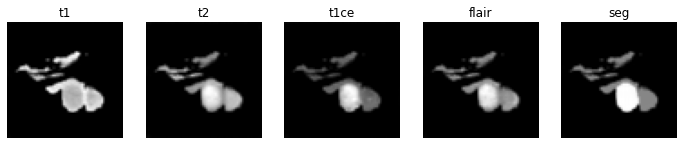

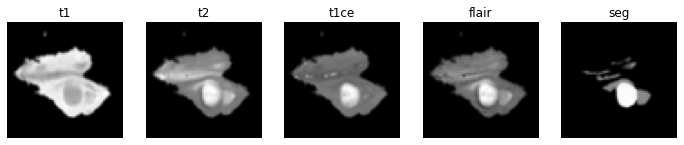

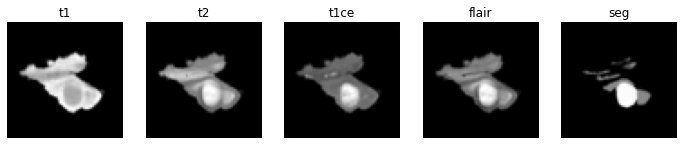

In [28]:
test_data = next(iter(dataloader_ts))
slice_idx = 40  # Assuming you have a predefined slice index

for condition in ['tum', 'surr1', 'surr2']:
    fig, axs = plt.subplots(1, len(modality_keys), figsize=(12, 4))  # Assuming modality_keys defined earlier
    for i, sequence in enumerate(['t1', 't2', 't1ce', 'flair','seg']):
        inputs = test_data[condition][sequence].to(device)
        outputs = model(inputs)
        
        # Validate model output structure or modify as per actual output
        image = outputs[0, 0, :, :, slice_idx].detach().cpu().numpy()  # Assuming outputs is a tensor
        axs[i].imshow(image, cmap='gray')
        axs[i].set_title(sequence)
        axs[i].axis('off')
    plt.show()

The output images are completely similar to the inputs so we can use them for feature reconstruction

Testing feature extraction

In [5]:
input_tensor = torch.rand(1, 1, 64, 64, 64)
device = torch.device("cuda:0" )#if torch.cuda.is_available() else "cpu")
model = swinunetplussig(device)
model_path = '/media/sdb/Maryam/surrounding_prognosis/saved_models/Reconstruction_epch_last.pth'
model.load_state_dict(torch.load(model_path))
input_tensor = input_tensor.to(device)
with torch.no_grad(): 
    features = model.ex_features(input_tensor)

In [7]:
flat_vector = features.flatten(start_dim=1)